In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

pd.options.display.max_rows = 20

In [2]:
df=pd.read_csv(r"E:\Programs\GDrive_Vikrantarora25\Analytics\Applied Analytics\TSA\Prophet\medium_posts.csv", sep='\t')
df.head()

,published,domain,url
0,2012-08-13 22:54:53.510Z,medium.com,https://medium.com/policy/medium-terms-of-serv...
1,2012-08-13 22:57:17.248Z,medium.com,https://medium.com/policy/medium-privacy-polic...
2,2016-11-04 23:40:43.364Z,medium.com,https://medium.com/@Medium/personalize-your-me...
3,2016-12-24 18:21:13.427Z,medium.com,https://medium.com/holiday-poems/xmas-morning-...
4,2015-09-22 21:37:48.207Z,blog.medium.com,https://blog.medium.com/taking-a-side-on-net-n...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92191 entries, 0 to 92190
Data columns (total 3 columns):
published    92191 non-null object
domain       92191 non-null object
url          92191 non-null object
dtypes: object(3)
memory usage: 2.1+ MB


In [4]:
#drpping domain as its not required for TSA
df.drop(columns='domain',inplace=True)

In [5]:
#Checking dups in url's
df.url.value_counts()

https://medium.com/iiot                                                                                                                25
http://www.fbi.gov                                                                                                                      3
https://medium.com/@rosaalegria/vis%C3%B5es-femininas-sobre-o-mundo-p%C3%B3s-desenvolvido-a085699d3d23                                  2
https://medium.com/@briansin/stemcentrx-abbvie-d0ba3dc51bd5                                                                             2
http://www.ehumandawn.blogspot.com/                                                                                                     2
https://medium.com/@pedrovarasb/fuck-you-emprendedor-rockstar-d38726f30470                                                              2
https://medium.com/@kevinhartz/my-next-chapter-d74b6883b88f                                                                             2
http://waxpackgods.com/1984-topps-

In [6]:
df[df['url']=='https://medium.com/@rosaalegria/vis%C3%B5es-femininas-sobre-o-mundo-p%C3%B3s-desenvolvido-a085699d3d23']

,published,url
74673,2017-03-08 12:01:03.383Z,https://medium.com/@rosaalegria/vis%C3%B5es-fe...
74675,2017-03-08 12:01:03.383Z,https://medium.com/@rosaalegria/vis%C3%B5es-fe...


In [7]:
#We have dups in our dataset so removing them
#Removing duplicates

print(df.shape)
dups_index=df[df['url'].duplicated(keep='first')].index

df.drop(index=dups_index,inplace=True)
print(df.shape)

(92191, 2)
(92144, 2)


In [8]:
df['published'] = pd.to_datetime(df['published'])

In [9]:
df.sort_values(by=['published']).head(n=3)

,published,url
40243,1970-01-01 00:00:00.001000+00:00,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
37398,1970-01-18 05:11:58.200000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


Medium’s public release date was August 15, 2012. But, as you can see from the data above, there are at least several rows with much earlier publication dates. They have somehow turned up in our dataset, but they are hardly legitimate ones. We will just trim our time series to keep only those rows that fall onto the period from August 15, 2012 to June 25, 2017:

In [10]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2017-06-26')].sort_values(by=['published'])
df.head(n=3)

,published,url
24630,2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...


In [11]:
#Removing time zone from ds column
df['published']=df['published'].dt.tz_localize(None)
df.head(3)

,published,url
24630,2012-08-15 00:25:03.373,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502,https://medium.com/i-m-h-o/the-world-is-social...


In [12]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']

In [13]:
aggr_df.head()

,posts
published,
2012-08-15 00:25:03.373,1
2012-08-15 00:25:29.419,1
2012-08-15 00:34:59.502,1
2012-08-15 00:40:10.773,1
2012-08-15 00:58:25.898,1


In [14]:
daily_df=aggr_df.resample(rule='D').sum()
daily_df.head()

,posts
published,
2012-08-15,16
2012-08-16,11
2012-08-17,4
2012-08-18,2
2012-08-19,1


# Exploratory visual analysis

In [15]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

# Initialize plotly
init_notebook_mode(connected=True)

In [16]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [17]:
plotly_df(daily_df, title='Posts on Medium (daily)')

To reduce the noise, we will resample the post counts down to weekly bins.

In [18]:
weekly_df=daily_df.resample("W").sum()
monthly_df=daily_df.resample("M").sum()

In [19]:
plotly_df(weekly_df, title='Posts on Medium (weekly)')

we’re going to omit the first few years of observations, up to 2015. First, they won’t contribute much into the forecast quality in 2017. Second, these first years, having very low number of posts per day, are likely to increase noise in our predictions, as the model would be forced to fit this abnormal historical data along with more relevant and indicative data from the recent years.

In [20]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head(n=3)

,posts
published,
2015-01-01,8
2015-01-02,11
2015-01-03,11


In [21]:
plotly_df(weekly_df,"Weekly Posts Since 2015")

In [22]:
monthly_df.head()

,posts
published,
2012-08-31,39
2012-09-30,10
2012-10-31,12
2012-11-30,29
2012-12-31,17


In [23]:
plotly_df(monthly_df.loc["2015-01-31":])

In [67]:
daily_df.reset_index(inplace=True)

daily_df['weekday']= daily_df['published'].dt.weekday_name
daily_df.head(3)

,published,posts,weekday
0,2015-01-01,8,Thursday
1,2015-01-02,11,Friday
2,2015-01-03,11,Saturday


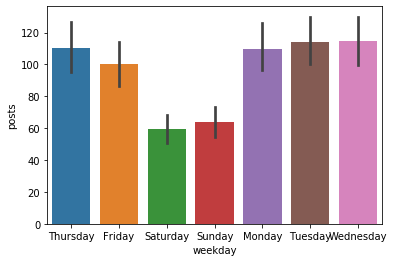

In [68]:
sns.barplot(x=daily_df['weekday'],y=daily_df['posts'],estimator=np.mean);

There is weekly seasonality, Sat & Sun recieve very low traffic and Mon to thur its high

# Checking for type of seasonality

In [69]:
def movingavg(interval,window_size):
    window=np.ones(int(window_size))/float(window_size)
    return pd.DataFrame(np.convolve(interval,window,"valid"),columns=['Moving Avg'])

MA=movingavg(daily_df["posts"],7)
MA.round(0).head(10)

,Moving Avg
0,15.0
1,18.0
2,18.0
3,18.0
4,18.0
5,18.0
6,18.0
7,17.0
8,17.0
9,17.0


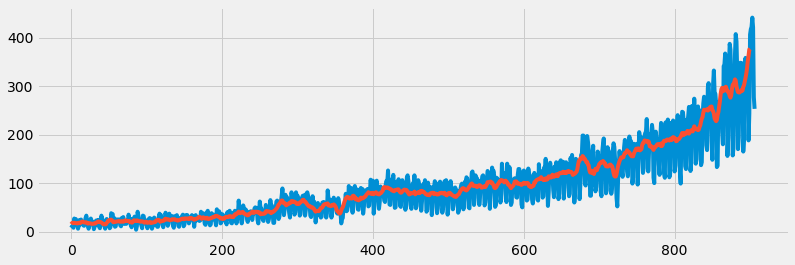

In [70]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,4))
plt.plot(daily_df['posts'])
plt.plot(MA['Moving Avg'])
plt.show();

This graph shows there is high variation in daily sessions and weekly moving average sessions is much smoother

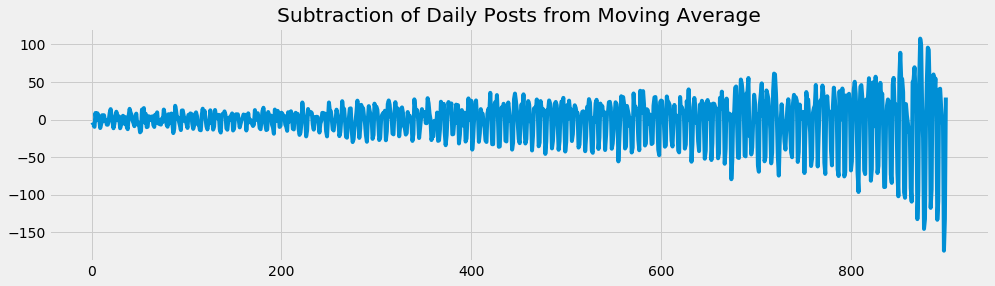

In [73]:
#Subtraction of moving avg from the observed values------ADDITIVE TS CHECK

plt.figure(figsize=(15,4))
plt.plot(daily_df['posts']-MA['Moving Avg'])
plt.title("Subtraction of Daily Posts from Moving Average");

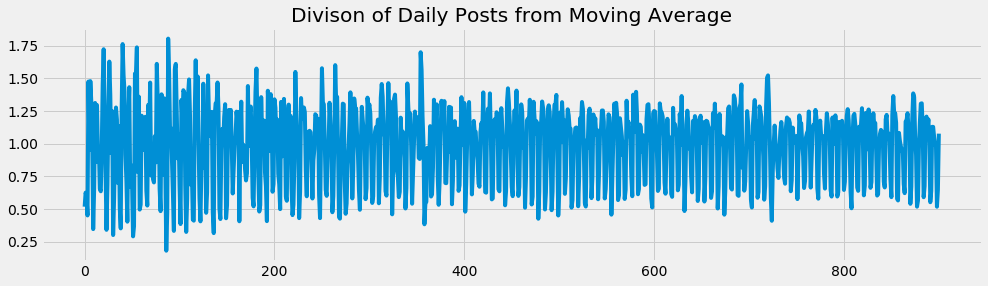

In [75]:
#Divison of the observed values by moving avg------Multi. TS CHECK
plt.figure(figsize=(15,4))
plt.plot(daily_df['posts']/MA['Moving Avg']);

plt.title("Divison of Daily Posts from Moving Average");

**DIVISION GRAPH Shows much more smooth trend (less fluctuations compared to subtraction graph) indicating TS is multiplicative mostly**

# Data Prep before Model Building

In [24]:
#we’ll import the library and mute unimportant diagnostic messages:
from fbprophet import Prophet


import logging
logging.getLogger().setLevel(logging.ERROR)

In [25]:
#convert our dataframe to the format required by Prophet:
df=daily_df.reset_index()
df.columns=['ds','y']
df.tail()

,ds,y
902,2017-06-21,422
903,2017-06-22,441
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


**The authors of the library generally advise to make predictions based on at least several months, ideally, more than a year of historical data.**

In [26]:
print(df['ds'].min())
print(df['ds'].max())
print(df['ds'].min()-df['ds'].max())

2015-01-01 00:00:00
2017-06-25 00:00:00
-906 days +00:00:00


**We have data for approx 2.5 years or 906 days, so lets split data into train and test with a test size of ~1 month as is generally needed in web data (being very dynamic short forecats are more prefered over long ones)**

In [27]:
prediction_size = 30 
train_df = df[:-prediction_size]
train_df.tail(n=3)

,ds,y
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


In [28]:
test_df=df[-prediction_size:]
test_df.head(3)

,ds,y
877,2017-05-27,157
878,2017-05-28,172
879,2017-05-29,297


In [29]:
model = Prophet(growth='linear', seasonality_mode='multiplicative')
model.fit(train_df)

In [30]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None})])

Using the helper method Prophet.make_future_dataframe, we create a dataframe which will contain all dates from the history and also extend into the future for those 30 days that we left out before.

In [31]:
future = model.make_future_dataframe(periods=prediction_size, freq='D')
future.tail(n=3)

,ds
904,2017-06-23
905,2017-06-24
906,2017-06-25


We predict values with Prophet by passing in the dates for which we want to create a forecast. If we also supply the historical dates (as in our case), then in addition to the prediction we will get an in-sample fit for the history. Let's call the model's predict method with our future dataframe as an input:

In [32]:
forecast=model.predict(future)
forecast.head(n=5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2015-01-01,17.000402,0.492620,34.234453,17.000402,17.000402,0.028599,0.028599,0.028599,0.142519,0.142519,0.142519,-0.113920,-0.113920,-0.113920,0.0,0.0,0.0,17.486591
1,2015-01-02,17.050880,-0.041601,32.378672,17.050880,17.050880,-0.067221,-0.067221,-0.067221,0.041787,0.041787,0.041787,-0.109008,-0.109008,-0.109008,0.0,0.0,0.0,15.904704
2,2015-01-03,17.101358,-7.307749,25.466023,17.101358,17.101358,-0.468805,-0.468805,-0.468805,-0.365018,-0.365018,-0.365018,-0.103787,-0.103787,-0.103787,0.0,0.0,0.0,9.084152
3,2015-01-04,17.151836,-6.941789,26.542343,17.151836,17.151836,-0.437774,-0.437774,-0.437774,-0.339475,-0.339475,-0.339475,-0.098300,-0.098300,-0.098300,0.0,0.0,0.0,9.643203
4,2015-01-05,17.202314,1.541904,34.374912,17.202314,17.202314,0.055992,0.055992,0.055992,0.148580,0.148580,0.148580,-0.092588,-0.092588,-0.092588,0.0,0.0,0.0,18.165500


In [33]:
test_df.head(5)

,ds,y
877,2017-05-27,157
878,2017-05-28,172
879,2017-05-29,297
880,2017-05-30,365
881,2017-05-31,407


In [34]:
forecast.iloc[-30:,].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
877,2017-05-27,250.925183,178.742845,212.054028,250.925183,250.925183,-0.224799,-0.224799,-0.224799,-0.365018,-0.365018,-0.365018,0.140219,0.140219,0.140219,0.0,0.0,0.0,194.517571
878,2017-05-28,251.552171,183.595414,216.644395,251.552171,251.552171,-0.201123,-0.201123,-0.201123,-0.339475,-0.339475,-0.339475,0.138352,0.138352,0.138352,0.0,0.0,0.0,200.959248
879,2017-05-29,252.179159,306.302083,340.840266,252.179159,252.179159,0.284261,0.284261,0.284261,0.148580,0.148580,0.148580,0.135680,0.135680,0.135680,0.0,0.0,0.0,323.863736
880,2017-05-30,252.806147,317.300065,351.706618,252.806147,252.806147,0.320896,0.320896,0.320896,0.188651,0.188651,0.188651,0.132245,0.132245,0.132245,0.0,0.0,0.0,333.930718
881,2017-05-31,253.433135,314.341636,348.252499,253.433135,253.433135,0.311056,0.311056,0.311056,0.182955,0.182955,0.182955,0.128101,0.128101,0.128101,0.0,0.0,0.0,332.264958


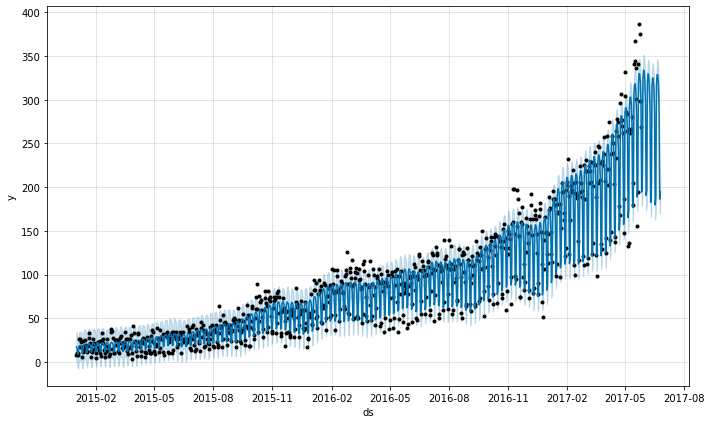

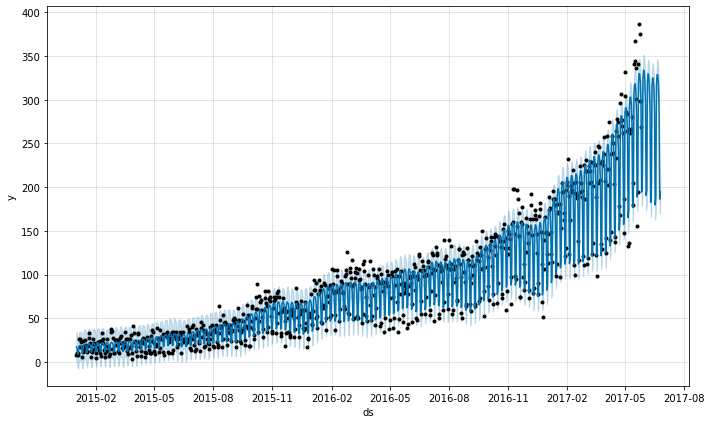

In [35]:
model.plot(forecast)

Model performs badly after 2015 and is unable to predict steep increase in 2016 as 2015 had much lower posts

Seasonality is not captured as so many black points (actuals) diverge highly from predictions

In [55]:
def mape(y_true, y_pred):
    y_true, y_pred= np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [56]:
mape(test_df["y"],forecast.loc[877:,"yhat"])

13.593573210236798

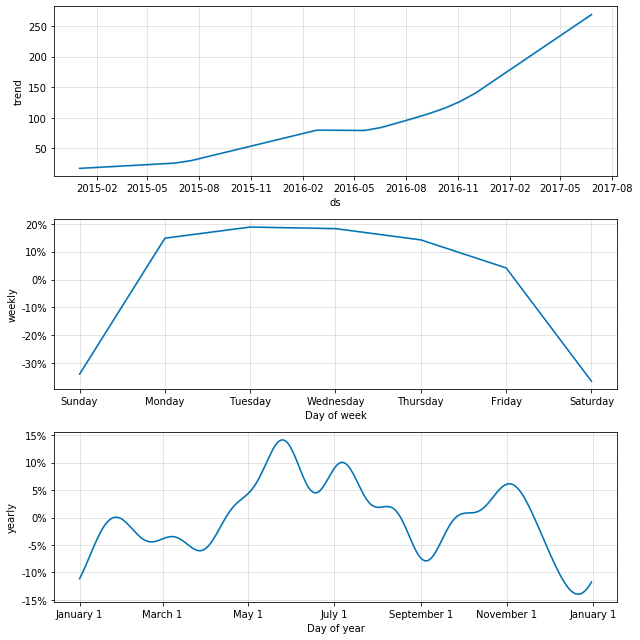

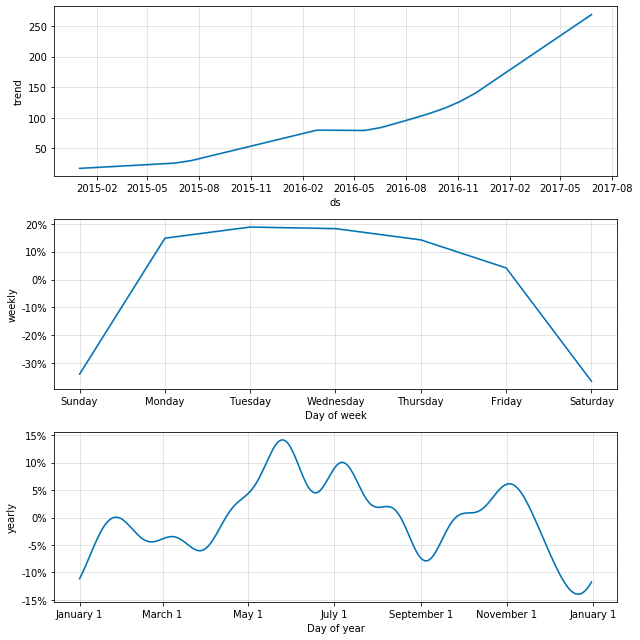

In [38]:
#model self identifies weekly and yearly seasonality
model.plot_components(forecast)

In [39]:
df1=df.set_index(df['ds'])
df1.resample("A").mean()
#AVERAGE MONTHLY POSTS 

,y
ds,
2015-12-31,33.063014
2016-12-31,97.658470
2017-12-31,222.857955


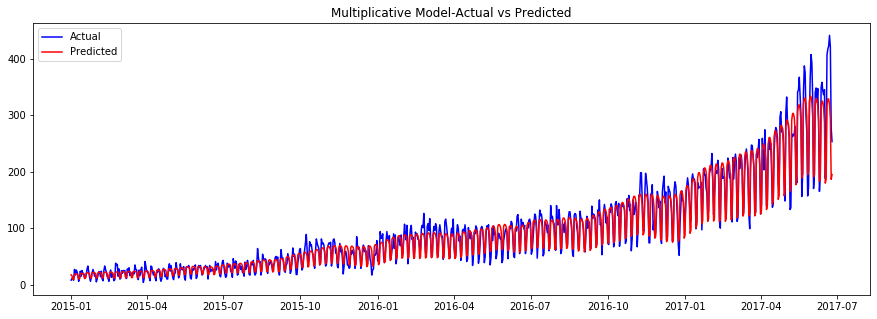

In [40]:
plt.figure(figsize=(15,5))
plt.plot(df['ds'],df['y'],label='Actual',color='blue')
plt.plot(df['ds'],forecast['yhat'],label="Predicted",color='red')
plt.legend()
plt.title("Multiplicative Model-Actual vs Predicted")
plt.show();

**ZOOMING ON 2017: Due to much lower values of May in 2015 & 2016 (~2300 in 2016) vs ~8600 in 2017 model is underpredicting.

**REASON WHY MODEL PERFORMS POORLY IS DUE TO THE FACT THAT THERE IS STEEP INCREASES FROM PREVIOUS YEAR (2016 IS V HIGH VS 2015 AND 2017 IS V HIGH VS 2016)> THIS HIGH VARIANCE IS LEADING TO INACCURATE PREDICTIONS***



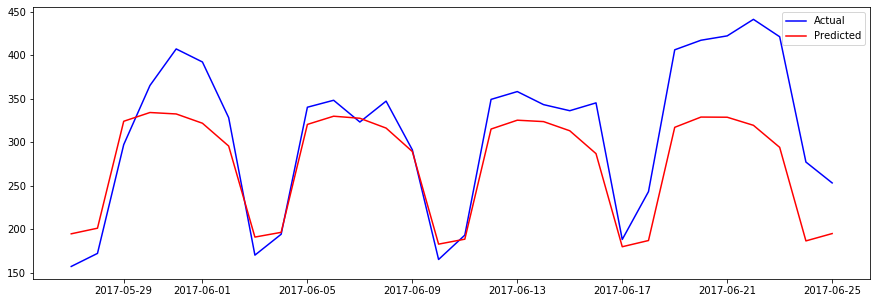

In [41]:
plt.figure(figsize=(15,5))
plt.plot(test_df['ds'],test_df['y'],label='Actual',color='blue')
plt.plot(forecast.loc[877:,'ds'],forecast.loc[877:,'yhat'],label="Predicted",color='red')
plt.legend()
plt.show();

**We need to do something about this steep increase in Mar 2017 to improve our predictions**

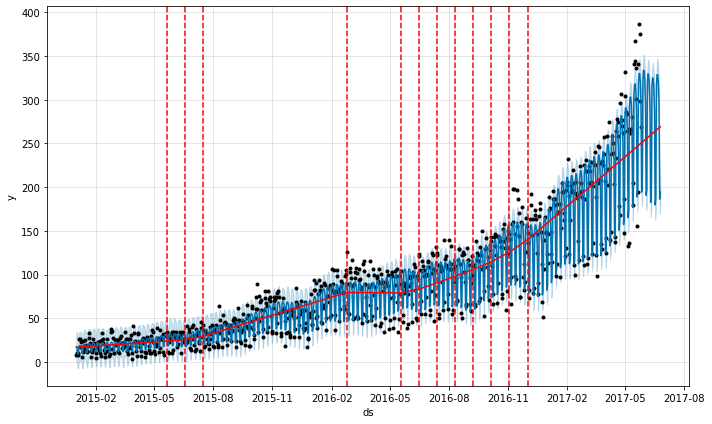

In [42]:
from fbprophet.plot import add_changepoints_to_plot
figure = model.plot(forecast)
a=add_changepoints_to_plot(figure.gca(),model,forecast)

#the red lines are change points 
#the change points are only fitted for the 1st 80% of the time series, allowing sufficient runway for the actual forecast


#https://xang1234.github.io/prophet/
#https://facebook.github.io/prophet/docs/trend_changepoints.html

# Tuning the model

**To adjust the trend change (steep increases in 2016 in train data), we can use the parameter changepoint_prior_scale which is set to 0.05 by default. Increasing its value would make the trend more flexible and reduce underfitting, at the risk of overfitting**

Let us set it to 0.5 as suggested by the Prophet Documentation Guide. 

In [63]:
model_1=Prophet(changepoint_prior_scale=0.5,seasonality_mode='multiplicative')
model_1.fit(train_df)
forecast_1=model_1.predict(future)

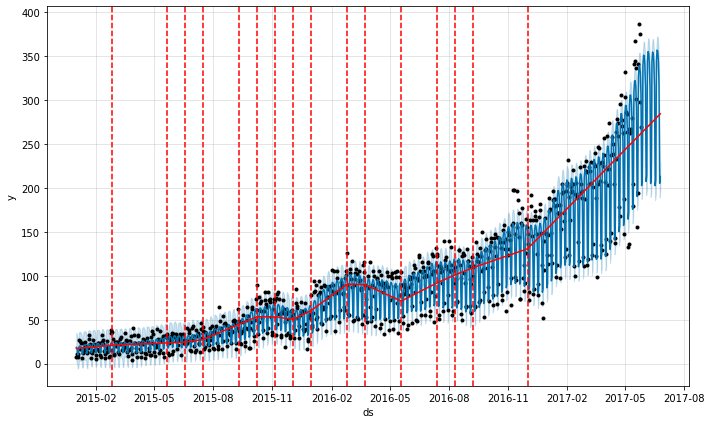

In [64]:
figure = model_1.plot(forecast_1)
a=add_changepoints_to_plot(figure.gca(),model_1,forecast_1)

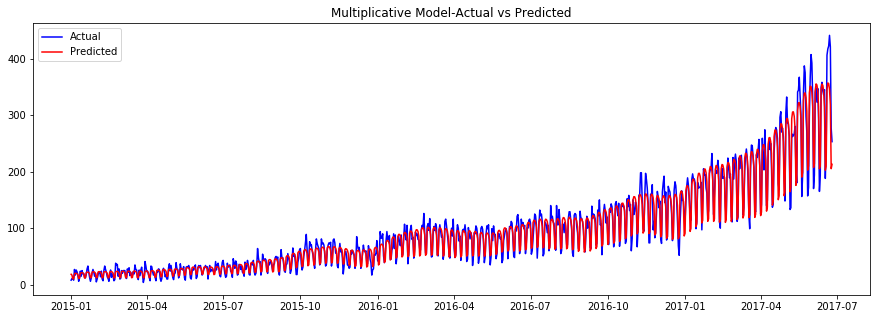

In [65]:
plt.figure(figsize=(15,5))
plt.plot(df['ds'],df['y'],label='Actual',color='blue')
plt.plot(df['ds'],forecast_1['yhat'],label="Predicted",color='red')
plt.legend()
plt.title("Multiplicative Model-Actual vs Predicted")
plt.show();

**Visually it appears with increase in changepoint_prior_scale to 1, predictions are better and mpae has reduced to 31 from 40**

In [66]:
mape(test_df["y"],forecast_1.loc[877:,"yhat"])

11.974065529717901

# Baseline Model

In [47]:
#We have weekly seasonality so a snaive naive would be a right baseline model 
#(seasonal naive) is a model that makes constant predictions taking into account information about seasonality. For instance, in the case of weekly seasonal data for each future Monday, we would predict the value from the last Monday, and for all future Tuesdays we would use the value from the last Tuesday and so on.

baseline_df=pd.concat([df,df['y'].shift(7)],axis=1)
baseline_df.columns=['ds',"y","y-7"]
baseline_df.head(15)

,ds,y,y-7
0,2015-01-01,8,NaN
1,2015-01-02,11,NaN
2,2015-01-03,11,NaN
3,2015-01-04,8,NaN
4,2015-01-05,27,NaN
5,2015-01-06,17,NaN
6,2015-01-07,26,NaN
7,2015-01-08,23,8.0
8,2015-01-09,17,11.0
9,2015-01-10,6,11.0


In [48]:
prediction_size = 30 
baseline_train_df= baseline_df[:-prediction_size]
baseline_train_df.tail(n=3)

,ds,y,y-7
874,2017-05-24,375,367.0
875,2017-05-25,298,336.0
876,2017-05-26,269,301.0


In [49]:
baseline_test_df=baseline_df[-30:]
baseline_test_df.head()

,ds,y,y-7
877,2017-05-27,157,156.0
878,2017-05-28,172,194.0
879,2017-05-29,297,341.0
880,2017-05-30,365,387.0
881,2017-05-31,407,375.0


In [58]:
mape(baseline_test_df["y"],baseline_test_df["y-7"])

12.121622698118749

**Model_1 MAPE is 11.97% which beats seasonal naive baseline Model MAPE=12.1%**

# Cross Validation

In [51]:
from fbprophet.diagnostics import cross_validation

cv_results=cross_validation(model,initial='730 days', horizon='30 days')

#https://facebook.github.io/prophet/docs/diagnostics.html

In [52]:
cv_results

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-12,185.319744,172.012798,198.965586,187,2017-01-11
1,2017-01-13,173.294773,160.294094,187.796977,180,2017-01-11
2,2017-01-14,113.951724,99.863612,127.490789,99,2017-01-11
3,2017-01-15,122.361955,108.461330,135.559556,112,2017-01-11
4,2017-01-16,193.776507,179.710742,206.482727,181,2017-01-11
5,2017-01-17,201.206383,188.297857,214.490554,171,2017-01-11
6,2017-01-18,204.101660,191.152154,216.762370,172,2017-01-11
7,2017-01-19,193.323590,179.113857,206.833358,172,2017-01-11
8,2017-01-20,179.326090,165.982683,192.316546,181,2017-01-11
9,2017-01-21,117.473878,103.858345,131.319427,97,2017-01-11


# Performance Evaluation

In [53]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results,rolling_window=0.2) #rolling_win is proportion of horizon period (in this case its 7days)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,6 days,527.420354,22.965634,18.701674,0.100259,0.375000
1,7 days,709.514729,26.636718,22.244156,0.115560,0.291667
2,8 days,736.561887,27.139674,22.131285,0.110073,0.354167
3,9 days,793.349354,28.166458,22.883172,0.112130,0.375000
4,10 days,1065.836807,32.647156,26.449203,0.127750,0.312500
5,11 days,1120.753766,33.477661,26.956229,0.132098,0.333333
6,12 days,1089.268323,33.004065,27.047408,0.135431,0.333333
7,13 days,1112.237804,33.350229,26.598242,0.132281,0.333333
8,14 days,1253.227920,35.400959,28.051372,0.137339,0.333333
9,15 days,1296.575553,36.007993,28.871223,0.139216,0.333333


Interpretation of CV results performace data:

- **forecast that errors around 11% are typical for predictions one week into the future, and that errors increase up to around 20% for predictions that are a month out.**

- The metrics in above df represent avg of horizon mentiioned, e.g.7 days MAPE represents avg of weekly MAPE for the weeks in time period 2017-01-12 to  2017-05-26	


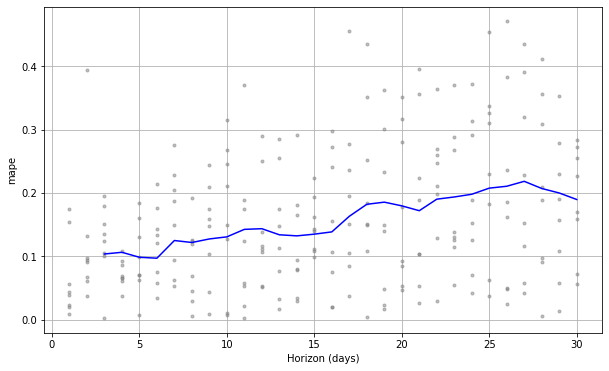

In [54]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')

- **With increasing horizon MAPE increases**

- **Points are so much scattered indicating that MAPE has high variation because series has high variation and is unstable** 

# Box -Cox to further imporove performance

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc

In [76]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [78]:
#prepare our dataset by setting its index:
train_df2 = train_df.copy().set_index('ds')

In [80]:
#we apply the function stats.boxcox from Scipy, which applies the Box–Cox transformation. 
# it will return two values. The first one is the transformed series and the second one is the found value of λ that is optimal in terms of the maximum log-likelihood:
from scipy import stats
import statsmodels.api as sm

train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)
lambda_prophet

0.19487069258480444

In [81]:
train_df2.head(3)

,ds,y
0,2015-01-01,2.563935
1,2015-01-02,3.056629
2,2015-01-03,3.056629


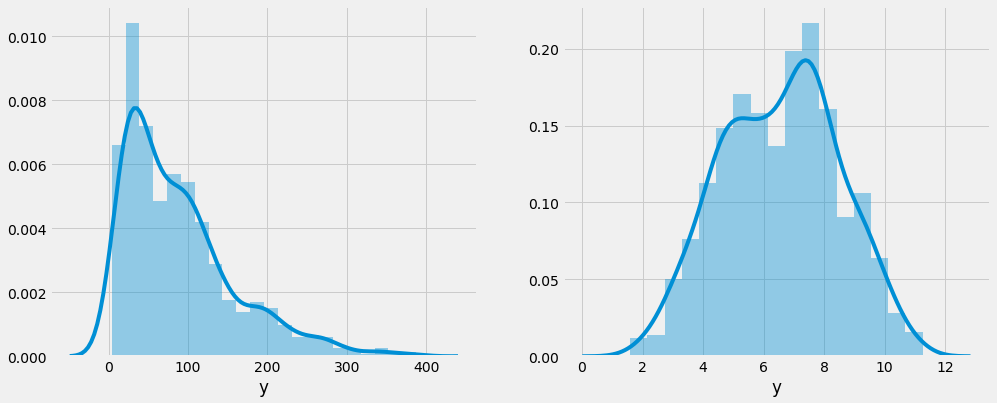

In [84]:
fig,ax=plt.subplots(1,2,figsize=(15,6))

sns.distplot(train_df['y'],ax=ax[0])
sns.distplot(train_df2['y'],ax=ax[1]);

Box cox transformed data is quite normal

### Checking Seasonality of logged data

In [99]:
def movingavg(interval,window_size):
    window=np.ones(int(window_size))/float(window_size)
    return pd.DataFrame(np.convolve(interval,window,"valid"),columns=['Moving Avg'])

MA=movingavg(train_df2["y"],7)
MA.round(0).head(5)

,Moving Avg
0,3.0
1,4.0
2,4.0
3,4.0
4,4.0


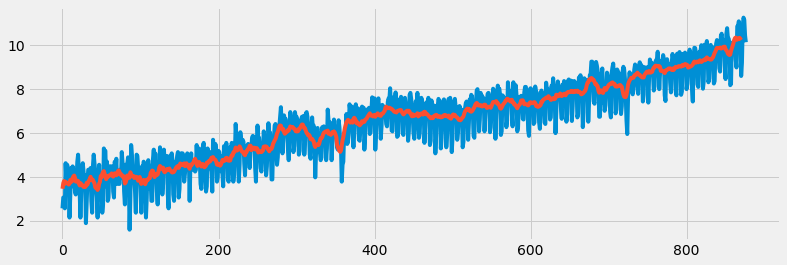

In [100]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,4))
plt.plot(train_df2['y'])
plt.plot(MA['Moving Avg'])
plt.show();

This graph shows there is high variation in daily sessions and weekly moving average sessions is much smoother

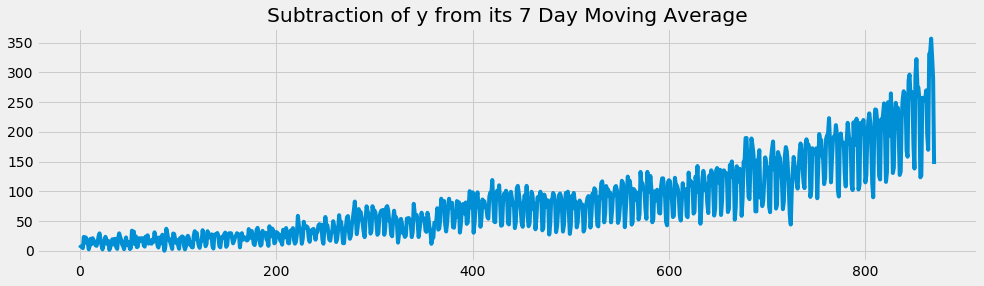

In [101]:
#Subtraction of moving avg from the observed values------ADDITIVE TS CHECK

plt.figure(figsize=(15,4))
plt.plot(train_df['y']-MA['Moving Avg'])
plt.title("Subtraction of y from its 7 Day Moving Average");

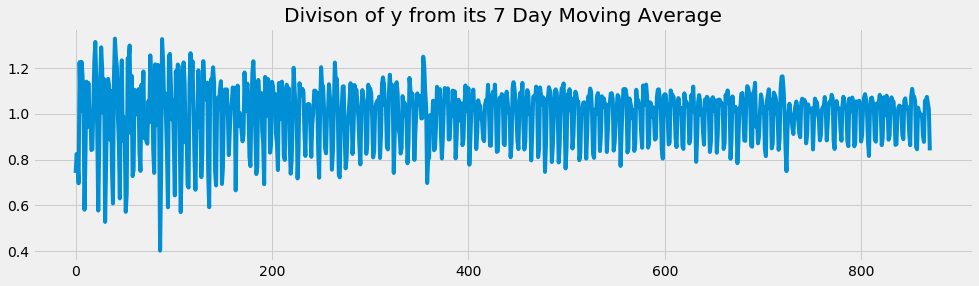

In [102]:
#Divison of the observed values by moving avg------Multi. TS CHECK
plt.figure(figsize=(15,4))
plt.plot(train_df2['y']/MA['Moving Avg']);

plt.title("Divison of y from its 7 Day Moving Average");

**DIVISION GRAPH Shows much more smooth trend (less fluctuations compared to subtraction graph) indicating TS is multiplicative mostly**

**Further check using Coeff of variation shows multiplicative seasonality as CV of Divison series is much less than Subtraction Series**

In [110]:
def coeffvar(series):
    return (np.std(series)/np.mean(series))*100

In [111]:
Subtraction = abs(train_df2['y']-MA['Moving Avg'])
coeffvar(Subtraction)

66.03720563496313

In [113]:
Divison = train_df2['y']/MA['Moving Avg']

coeffvar(Divison)

12.97027699206928

In [94]:
model_2=Prophet(changepoint_prior_scale=0.5, seasonality_mode='multiplicative')
model_2.fit(train_df2)
forecast_2=model_2.predict(future)

In [95]:
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_2[col] = inverse_boxcox(forecast_2[col],
                                       lambda_prophet)

In [96]:
mape(test_df["y"],forecast_2.loc[877:,"yhat"])

10.921892086727429

**Voila: Improvement from 11.98% to 10.92% in MAPE with Box Cox transformation vs without it**

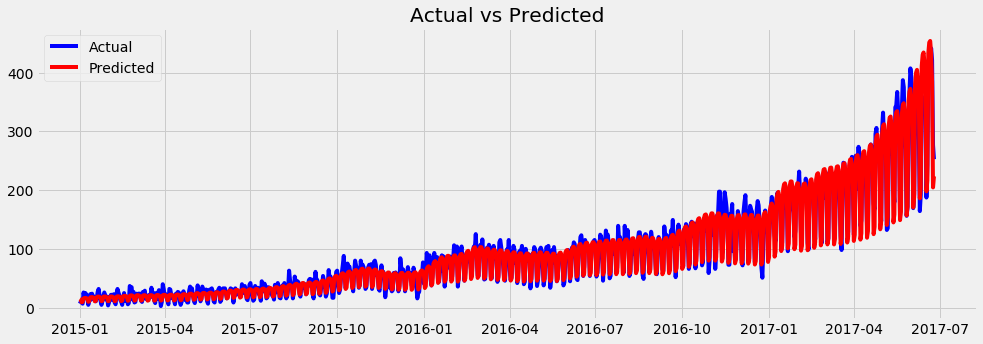

In [97]:
plt.figure(figsize=(15,5))
plt.plot(df['ds'],df['y'],label='Actual',color='blue')
plt.plot(df['ds'],forecast_2['yhat'],label="Predicted",color='red')
plt.legend()
plt.title("Actual vs Predicted")
plt.show();

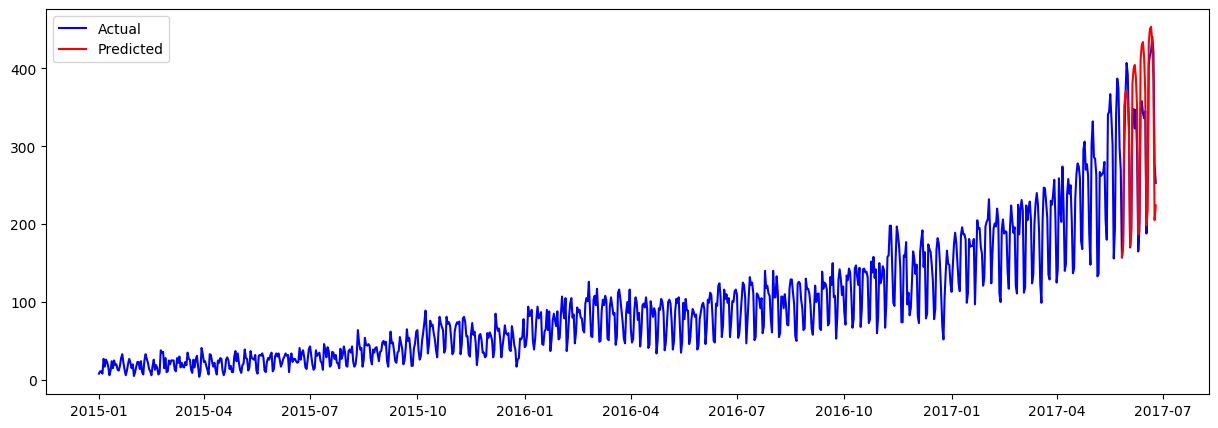

In [116]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

plt.figure(figsize=(15,5))
plt.plot(df['ds'],df['y'],label='Actual',color='blue')
plt.plot(forecast_2.loc[877:,'ds'],forecast_2.loc[877:,'yhat'],label="Predicted",color='red')
plt.legend()
plt.show();

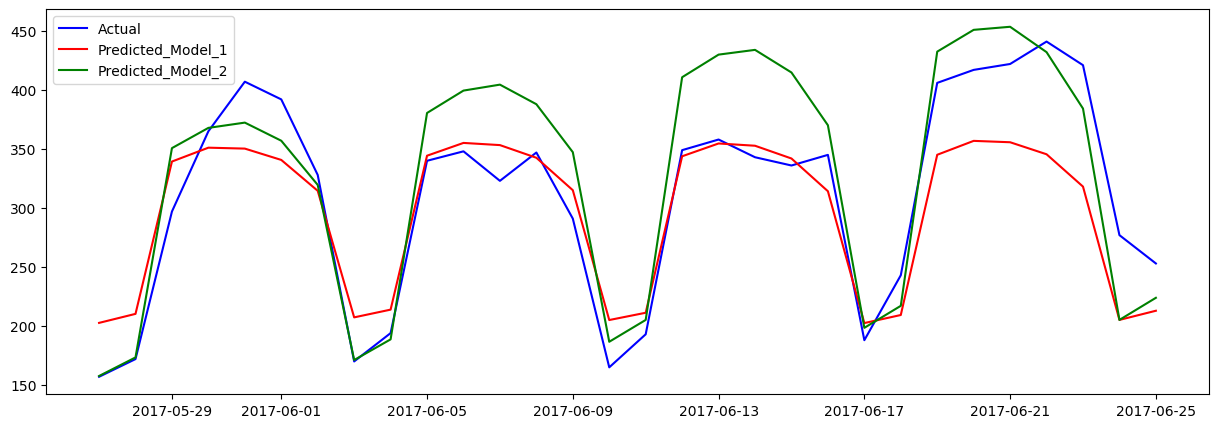

In [118]:
plt.figure(figsize=(15,5))
plt.plot(test_df['ds'],test_df['y'],label='Actual',color='blue')
plt.plot(forecast_1.loc[877:,'ds'],forecast_1.loc[877:,'yhat'],label="Predicted_Model_1",color='red')
plt.plot(forecast_2.loc[877:,'ds'],forecast_2.loc[877:,'yhat'],label="Predicted_Model_2",color='green')
plt.legend()
plt.show();